## Preambule

In [1]:
import numpy as np
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Run classes

In [78]:
import class_datareading
reload(class_datareading)
from class_datareading import datareading

datareader = datareading()
datareader.read_general()
datareader.read_ssps()
datareader.read_undata()
datareader.read_historicalemis()
datareader.read_ar6()
datareader.relation_budget_nonco2()
datareader.determine_global_nonco2_trajectories()
datareader.determine_global_budgets()
datareader.determine_global_co2_trajectories()
datareader.read_baseline()
datareader.read_ndc() 
datareader.merge_xr()
datareader.add_country_groups()
datareader.save()

# ==================================== #
# Initializing datareading class     #
# ==================================== #
- Reading general data
- Reading GDP and population data from SSPs
- Reading UN population data (for past population)
- Reading historical emissions (primap)
- Read AR6 data
- Get relationship between CO2 budgets and non-co2 reduction in 2050
- Computing global nonco2 trajectories
- Get global CO2 budgets
- Computing global co2 trajectories
- Reading baseline emissions
- Reading NDC data
- Merging xrarray object
- Add country groups
- Save important files
- Some pre-calculations for the AP allocation rule
- Some pre-calculations for the GDR allocation rule


In [91]:
import class_allocation

reload(class_allocation)
from class_allocation import allocation

for cty in tqdm(np.array(datareader.xr_total.Region)):
    allocator = allocation(cty)
    allocator.gf()  
    allocator.pc()
    allocator.pcc()
    allocator.ecpc()
    allocator.ap()
    allocator.gdr()
    allocator.save()

  0%|          | 1/207 [00:27<1:35:11, 27.72s/it]

In [74]:

        # Initialize data arrays for co2
        startpoint = self.xr_primap.sel(Time=self.settings['params']['start_year_analysis'], Region="EARTH").CO2_hist
        compensation_form = np.array(list(np.linspace(0, 1, len(np.arange(self.settings['params']['start_year_analysis'], 2101)))))#**1.1#+[1]*len(np.arange(2050, 2101)))
        xr_comp =  xr.DataArray(compensation_form, dims=['Time'], coords={'Time': np.arange(self.settings['params']['start_year_analysis'], 2101)})

        compensation_form2 = np.array(list(np.linspace(0, 1, len(np.arange(self.settings['params']['start_year_analysis'], 2101)))))**0.5#+[1]*len(np.arange(2050, 2101)))
        xr_comp2 =  xr.DataArray(compensation_form2, dims=['Time'], coords={'Time': np.arange(self.settings['params']['start_year_analysis'], 2101)})

        xr_traj_co2 = xr.Dataset(
            coords={
                'NegEmis': self.Neglist,
                'NonCO2red': self.NonCO2list,
                'Temperature': self.Tlist,
                'Risk': self.Plist,
                'Timing': self.Timinglist,
                'Time': np.arange(self.settings['params']['start_year_analysis'], 2101),
            }
        )

        pathways_data = {
            'CO2_globe': xr.DataArray(
                data=np.nan,
                coords=xr_traj_co2.coords,
                dims=('NegEmis', "NonCO2red", 'Temperature', 'Risk', 'Timing', 'Time'),
                attrs={'description': 'Pathway data'}
            )
        }

        xr_scen2_use = self.xr_ar6.sel(Variable='Emissions|CO2')
        xr_scen2_use = xr_scen2_use.reindex(Time = np.arange(2000, 2101, 10))
        xr_scen2_use = xr_scen2_use.reindex(Time = np.arange(2000, 2101))
        xr_scen2_use = xr_scen2_use.interpolate_na(dim="Time", method="linear")
        xr_scen2_use = xr_scen2_use.reindex(Time = np.arange(self.settings['params']['start_year_analysis'], 2101))

        co2_start = xr_scen2_use.sel(Time=self.settings['params']['start_year_analysis'])/1e3
        offsets = (startpoint/1e3-co2_start)
        emis_all = xr_scen2_use.sel(Time=np.arange(self.settings['params']['start_year_analysis'], 2101))/1e3 + offsets*(1-xr_comp)
        emis2100 = emis_all.sel(Time=2100)

        def remove_upward(ar):
            ar2 = np.zeros(len(ar))
            ar2[0:30] = ar[0:30]
            for i in range(30, len(ar)):
                if ar[i] > ar[i-1]:
                    ar2[i] = ar2[i-1]
                else:
                    ar2[i] = ar[i]
            return ar2

        def ms_temp(T):
            peaktemp = self.xr_ar6.sel(Variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').Value.max(dim='Time')
            return self.xr_ar6.ModelScenario[np.where((peaktemp < T+0.1) & (peaktemp > T-0.5))[0]] # 0.1 and 0.5 are chosen based on fitting with IPCC WGIII pathways from C1 and C3

        for temp_i, temp in enumerate([2.3]):
            ms1 = ms_temp(temp)
            # Shape impacted by timing of action
            for timing_i, timing in enumerate(['Delayed']):
                if timing == 'Immediate': mslist = self.ms_immediate
                if timing == 'Delayed': mslist = self.ms_delayed
                ms2 = np.intersect1d(ms1, mslist)
                emis2100_i = emis2100.sel(ModelScenario=ms2)
                if len(ms2) == 0: # TODO have a look at this, the 1.5 scenarios do not have delayed action
                    3
                else:
                    # The 90-percentile of 2100 emissions
                    ms_90 = self.xr_ar6.sel(ModelScenario=ms2).ModelScenario[(emis2100_i >= emis2100_i.quantile(0.9-0.1)
                                                ).Value & (emis2100_i <= emis2100_i.quantile(0.9+0.1)).Value]
                
                    # The 10-percentile of 2100 emissions
                    ms_10 = self.xr_ar6.sel(ModelScenario=ms2).ModelScenario[(emis2100_i >= emis2100_i.quantile(0.1-0.1)
                                                ).Value & (emis2100_i <= emis2100_i.quantile(0.1+0.1)).Value]

                    # Difference and smoothen this
                    surplus_factor = emis_all.sel(ModelScenario = np.intersect1d(ms_90, ms2)).mean(dim='ModelScenario').Value - emis_all.sel(ModelScenario = np.intersect1d(ms_10, ms2)).mean(dim='ModelScenario').Value
                    surplus_factor2 = np.convolve(surplus_factor, np.ones(3)/3, mode='valid')
                    surplus_factor[1:-1] = surplus_factor2

                    for neg_i, neg in enumerate([0.5]):
                        xset = emis_all.sel(ModelScenario=ms2)-surplus_factor*(neg-0.5)
                        for risk_i, risk in enumerate([0.83]):
                            for nonco2_i, nonco2 in enumerate([0.5]):
                                factor = (self.xr_co2_budgets.Budget.sel(Temperature=temp, Risk=risk, NonCO2red=nonco2) - xset.where(xset.Value > 0).sum(dim='Time')) / np.sum(compensation_form)
                                all_pathways = (1e3*(xset+factor*xr_comp)).Value/1e3
                                if len(all_pathways)>0:
                                    pathway = all_pathways.mean(dim='ModelScenario')
                                    pathway_sep = np.convolve(pathway, np.ones(3)/3, mode='valid') 
                                    pathway[1:-1] = pathway_sep
                                    offset = float(startpoint)/1e3 - pathway[0]
                                    pathway_final = np.array((pathway.T+offset)*1e3)

                                    # Remove upward emissions (harmonize later)
                                    pathway_final = remove_upward(np.array(pathway_final))

                                    # Harmonize by budget (iteration 3)
                                    factor = (self.xr_co2_budgets.Budget.sel(Temperature=temp, Risk=risk, NonCO2red=nonco2)*1e3 - pathway_final[pathway_final > 0].sum()) / np.sum(compensation_form)
                                    pathway_final2 = (1e3*(pathway_final+factor*xr_comp2))/1e3
                                    
        #                             pathways_data['CO2_globe'][neg_i, nonco2_i, temp_i, risk_i, timing_i, :] = pathway_final2
        # self.xr_traj_co2 = xr_traj_co2.update(pathways_data)
        # self.xr_traj_ghg_ds = (self.xr_traj_co2.CO2_globe+self.xr_traj_nonco2.NonCO2_globe*1e3)
        # self.xr_traj_ghg = xr.merge([self.xr_traj_ghg_ds.to_dataset(name="GHG_globe"), self.xr_traj_co2.CO2_globe, self.xr_traj_nonco2.NonCO2_globe*1e3])

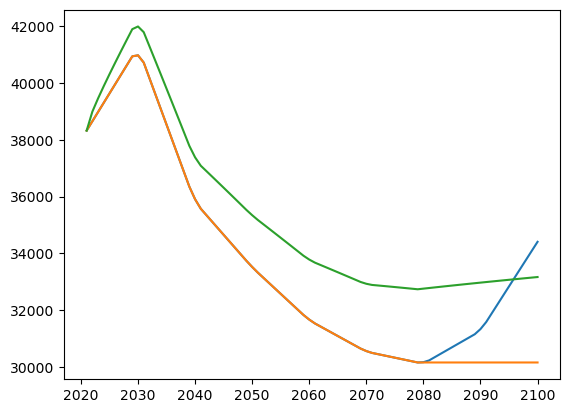

In [77]:
plt.plot(emis_all.Time, np.array((pathway.T+offset)*1e3))
plt.plot(emis_all.Time, pathway_final)
plt.plot(emis_all.Time, pathway_final2)


#+self.xr_traj_nonco2.NonCO2_globe.sel(NonCO2red=0.5, Timing='Delayed', Temperature=2.3)*1e3)
#plt.plot(datareader.xr_total.Time, datareader.xr_total.GHG_globe.sel(Temperature=2.3, Risk=0.83, NegEmis=0.5, Timing='Delayed', NonCO2red=0.5))

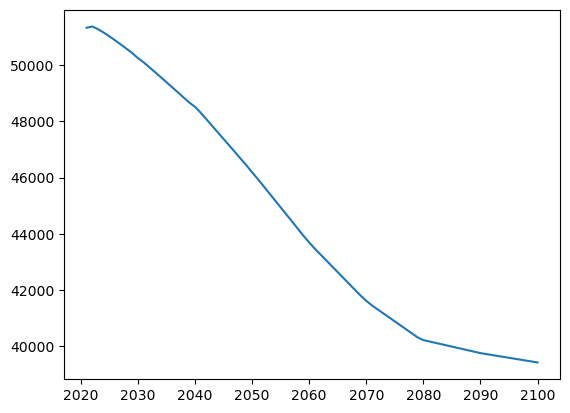

In [55]:
plt.plot(datareader.xr_total.Time, datareader.xr_total.GHG_globe.sel(Temperature=2.3, Risk=0.83, NegEmis=0.5, Timing='Immediate', NonCO2red=0.5))

In [6]:
import class_tempalign
reload(class_tempalign)
from class_tempalign import tempaligning

tempaligner = tempaligning() # FIRST RUN AGGREGATOR FOR THIS!! (2030 alloc)
tempaligner.get_relation_2030emis_temp()
tempaligner.determine_tempoutcomes()
tempaligner.save()

# ==================================== #
# Initializing tempaligning class        #
# ==================================== #
- Determine relation between 2030-emissions and temperature outcome
- Determine temperature metric


100%|██████████| 6/6 [00:53<00:00,  8.99s/it]


- Save


In [4]:
import class_policyscens
reload(class_policyscens)
from class_policyscens import policyscenadding

policyscenner = policyscenadding()
policyscenner.read_engage_data()
policyscenner.filter_and_convert()
policyscenner.add_to_xr()

# ==================================== #
# Initializing policyscenadding class  #
# ==================================== #
- Read ENGAGE scenarios and change region namings
- Filter correct scenarios and convert to xarray object
- Add to overall xrobject
